# Dataset Balance & Outlier Analysis

This notebook analyses **class balance** and **outlier removal impact** on the preprocessed EMG-EPN612 `dataset_TRAINING`.

## Contents
1. Load dataset & outlier reports
2. Overall class distribution
3. Bar-chart of class counts
4. Percentage distribution (pie chart)
5. Per-user class balance (Imbalance Ratio)
6. Per-user class-count heatmap
7. **Outlier Report — By Gesture**
8. **Outlier Report — By User**
9. **Outlier Report — By User × Gesture (cross-tab)**
10. Summary & Verdict

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

plt.rcParams.update({"figure.dpi": 120, "axes.titlesize": 13, "axes.labelsize": 11})

## 1 — Load dataset & outlier reports

In [ ]:
DATA_DIR = "../preprocessed_output"

# ── Parquet dataset ──────────────────────────────────────────────────────
df = pd.read_parquet(f"{DATA_DIR}/dataset_TRAINING.parquet")

# ── Outlier reports ──────────────────────────────────────────────────────
rpt_gesture = pd.read_csv(f"{DATA_DIR}/outlier_report_by_gesture.csv")
rpt_user    = pd.read_csv(f"{DATA_DIR}/outlier_report_by_user.csv")
rpt_ug      = pd.read_csv(f"{DATA_DIR}/outlier_report_by_user_gesture.csv")

print(f"TRAINING dataset : {df.shape[0]:,} windows × {df.shape[1]} cols")
print(f"Users            : {df['user'].nunique()}")
print(f"Labels           : {sorted(df['label'].unique())}")
print(f"\nOutlier reports loaded:")
print(f"  by_gesture     : {rpt_gesture.shape}")
print(f"  by_user        : {rpt_user.shape}")
print(f"  by_user_gesture: {rpt_ug.shape}")

SVM dataset : 1,031,602 windows × 76 cols
DTW dataset : 1,010,311 windows → 44,819 unique repetitions
Labels (SVM): ['fist', 'noGesture', 'open', 'pinch', 'waveIn', 'waveOut']
Labels (DTW): ['fist', 'noGesture', 'open', 'pinch', 'waveIn', 'waveOut']

Outlier reports loaded:
  by_gesture     : (6, 9)
  by_user        : (306, 9)
  by_user_gesture: (1836, 8)


## 2 — Overall class distribution

In [ ]:
def class_distribution_table(df, name, unit="samples"):
    """Return a summary DataFrame with count, percentage, and ratio to majority."""
    counts = df["label"].value_counts().sort_index()
    total  = counts.sum()
    majority = counts.max()
    summary = pd.DataFrame({
        "count":      counts,
        "pct (%)":    (counts / total * 100).round(2),
        "ratio_to_majority": (counts / majority).round(4),
    })
    summary.index.name = "label"
    ir = majority / counts.min()
    print(f"\n{'='*50}")
    print(f"  {name} — Class Distribution")
    print(f"{'='*50}")
    print(f"  Total {unit} : {total:,}")
    print(f"  Majority class: {counts.idxmax()} ({majority:,})")
    print(f"  Minority class: {counts.idxmin()} ({counts.min():,})")
    print(f"  Imbalance Ratio (IR = max/min): {ir:.4f}")
    print(f"  Ideal balanced pct per class  : {100/len(counts):.2f}%")
    print()
    display(summary)
    return summary, ir

summary, ir = class_distribution_table(df, "TRAINING", unit="windows")


  SVM — Class Distribution
  Total windows : 1,031,602
  Majority class: waveOut (182,569)
  Minority class: open (154,780)
  Imbalance Ratio (IR = max/min): 1.1795
  Ideal balanced pct per class  : 16.67%



,count,pct (%),ratio_to_majority
label,,,
fist,179631,17.41,0.9839
noGesture,168678,16.35,0.9239
open,154780,15.00,0.8478
pinch,171806,16.65,0.9410
waveIn,174138,16.88,0.9538
waveOut,182569,17.70,1.0000



  DTW — Class Distribution
  Total repetitions : 44,819
  Majority class: pinch (7,563)
  Minority class: waveIn (7,389)
  Imbalance Ratio (IR = max/min): 1.0235
  Ideal balanced pct per class  : 16.67%



,count,pct (%),ratio_to_majority
label,,,
fist,7485,16.70,0.9897
noGesture,7426,16.57,0.9819
open,7498,16.73,0.9914
pinch,7563,16.87,1.0000
waveIn,7389,16.49,0.9770
waveOut,7458,16.64,0.9861


## 3 — Bar-chart of class counts

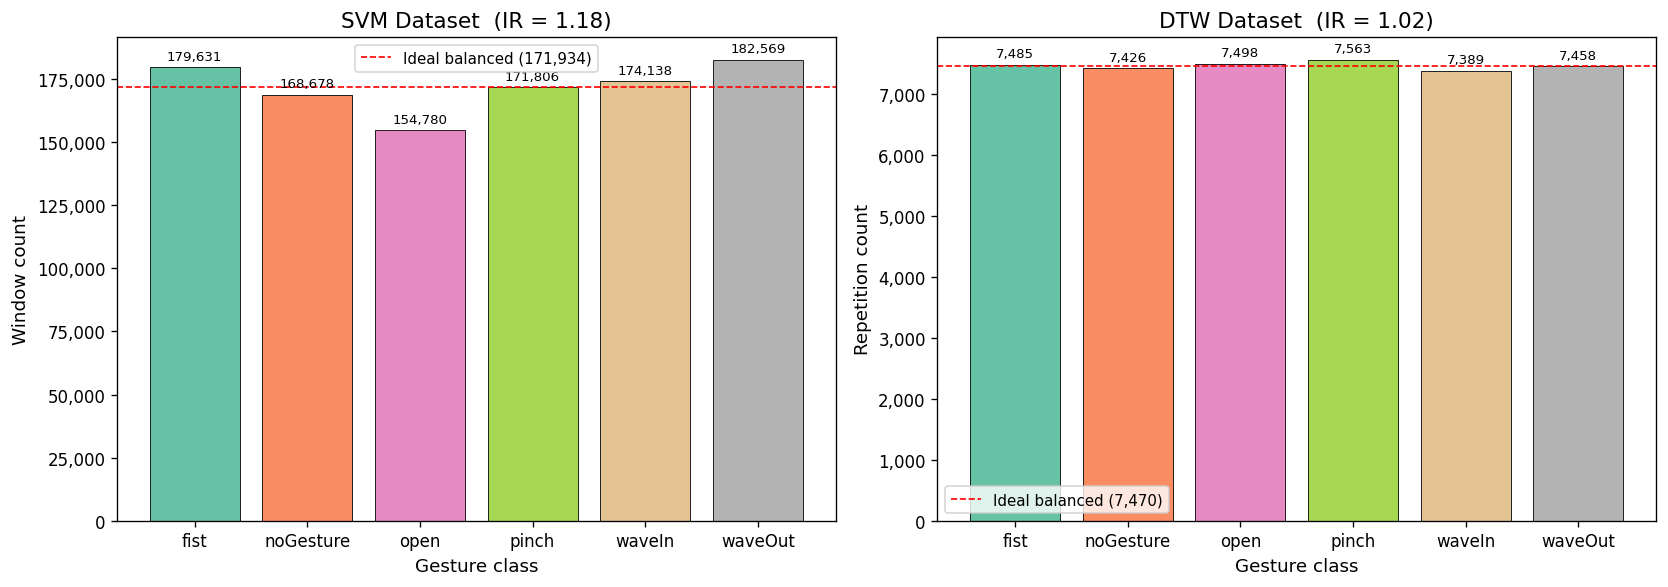

In [ ]:
labels_order = sorted(df["label"].unique())
counts = df["label"].value_counts().reindex(labels_order)
colours = plt.cm.Set2(np.linspace(0, 1, len(labels_order)))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels_order, counts, color=colours, edgecolor="black", linewidth=0.5)

# balanced reference line
balanced = counts.sum() / len(labels_order)
ax.axhline(balanced, ls="--", color="red", linewidth=1, label=f"Ideal balanced ({balanced:,.0f})")

# annotate bars
for bar, val in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + counts.max() * 0.01,
            f"{val:,}", ha="center", va="bottom", fontsize=9)

ax.set_title(f"TRAINING Dataset — Class Counts  (IR = {ir:.2f})")
ax.set_ylabel("Window count")
ax.set_xlabel("Gesture class")
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.tight_layout()
plt.show()

## 4 — Percentage distribution (pie chart)

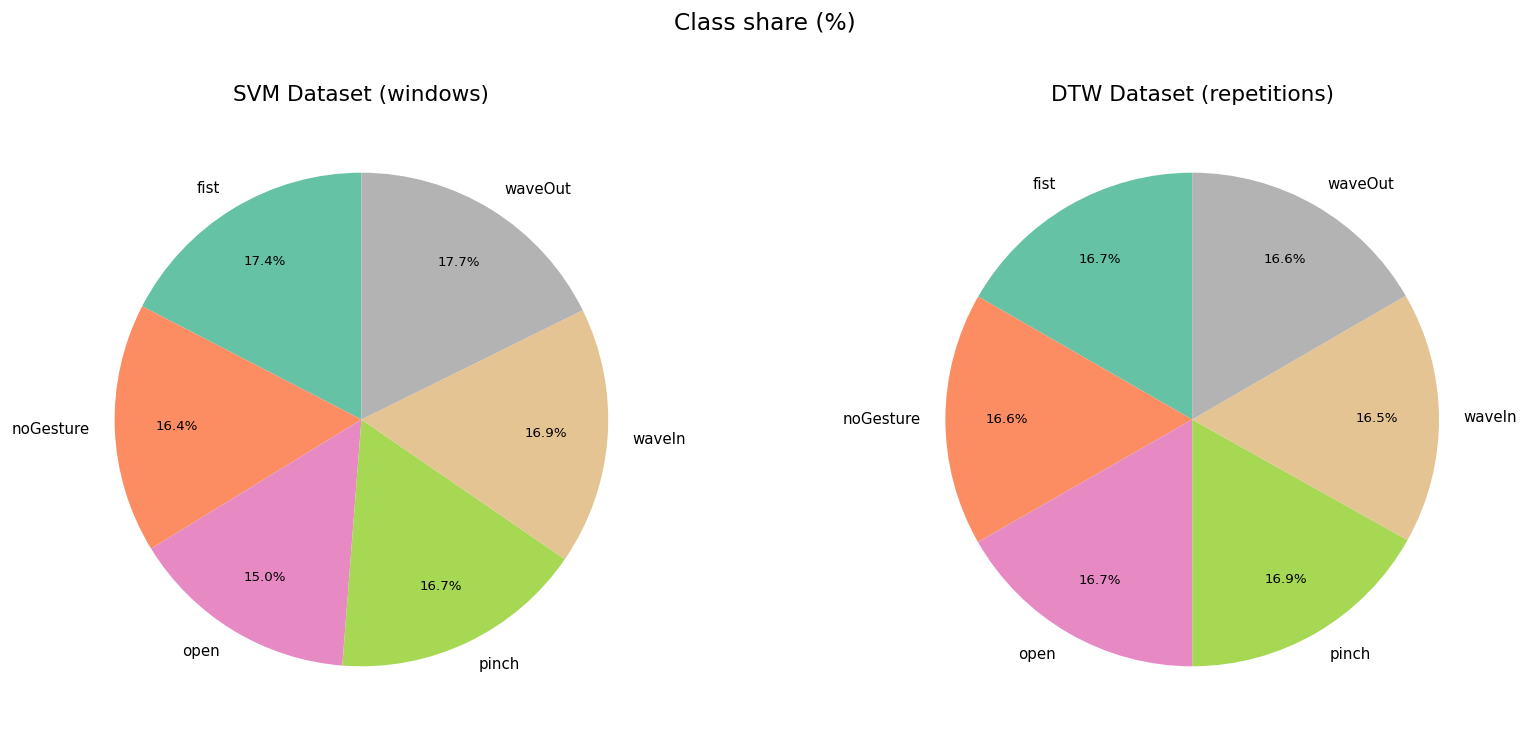

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

counts = df["label"].value_counts().reindex(labels_order)
colours = plt.cm.Set2(np.linspace(0, 1, len(labels_order)))
wedges, texts, autotexts = ax.pie(
    counts, labels=labels_order, autopct="%1.1f%%",
    colors=colours, startangle=90, pctdistance=0.75,
    textprops={"fontsize": 10},
)
for t in autotexts:
    t.set_fontsize(9)
ax.set_title("TRAINING Dataset — Class Share (%)")

plt.tight_layout()
plt.show()

## 5 — Per-user class balance

Compute the Imbalance Ratio (IR) for each user individually to check whether certain users are more imbalanced than others (counted per sliding window).

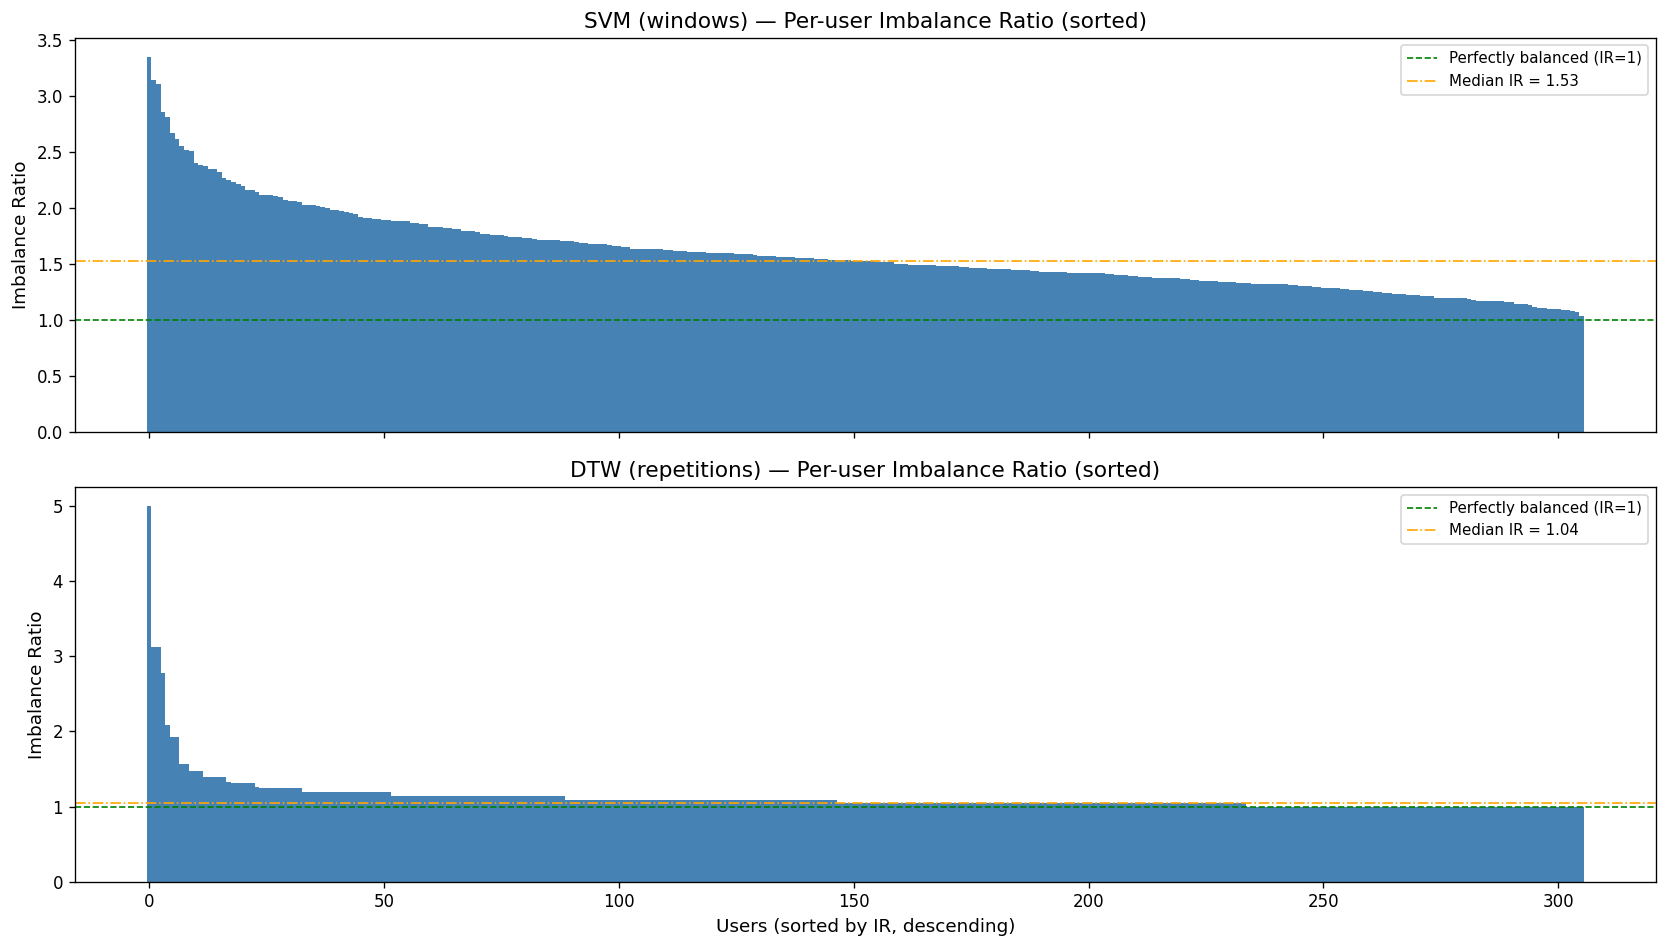

Per-user IR statistics:


,SVM (windows),DTW (repetitions)
count,306.0000,306.0000
mean,1.5965,1.1281
std,0.3695,0.3204
min,1.0387,1.0000
25%,1.3439,1.0417
50%,1.5282,1.0417
75%,1.7479,1.1364
max,3.3493,5.0000


In [ ]:
def per_user_ir(df):
    """Return a Series of per-user imbalance ratios."""
    def _ir(g):
        counts = g.value_counts()
        return counts.max() / counts.min() if counts.min() > 0 else np.inf
    return df.groupby("user")["label"].apply(_ir).rename("IR")

ir_vals = per_user_ir(df)

fig, ax = plt.subplots(figsize=(14, 5))
ir_sorted = ir_vals.sort_values(ascending=False)
ax.bar(range(len(ir_sorted)), ir_sorted.values, width=1.0, color="steelblue", edgecolor="none")
ax.axhline(1.0, ls="--", color="green", linewidth=1, label="Perfectly balanced (IR=1)")
ax.axhline(ir_vals.median(), ls="-.", color="orange", linewidth=1,
           label=f"Median IR = {ir_vals.median():.2f}")
ax.set_ylabel("Imbalance Ratio")
ax.set_xlabel("Users (sorted by IR, descending)")
ax.set_title("TRAINING — Per-user Imbalance Ratio (sorted)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print("Per-user IR statistics:")
display(ir_vals.describe().round(4).to_frame("IR"))

## 6 — Per-user class-count heatmap

Shows window counts per user × gesture class.

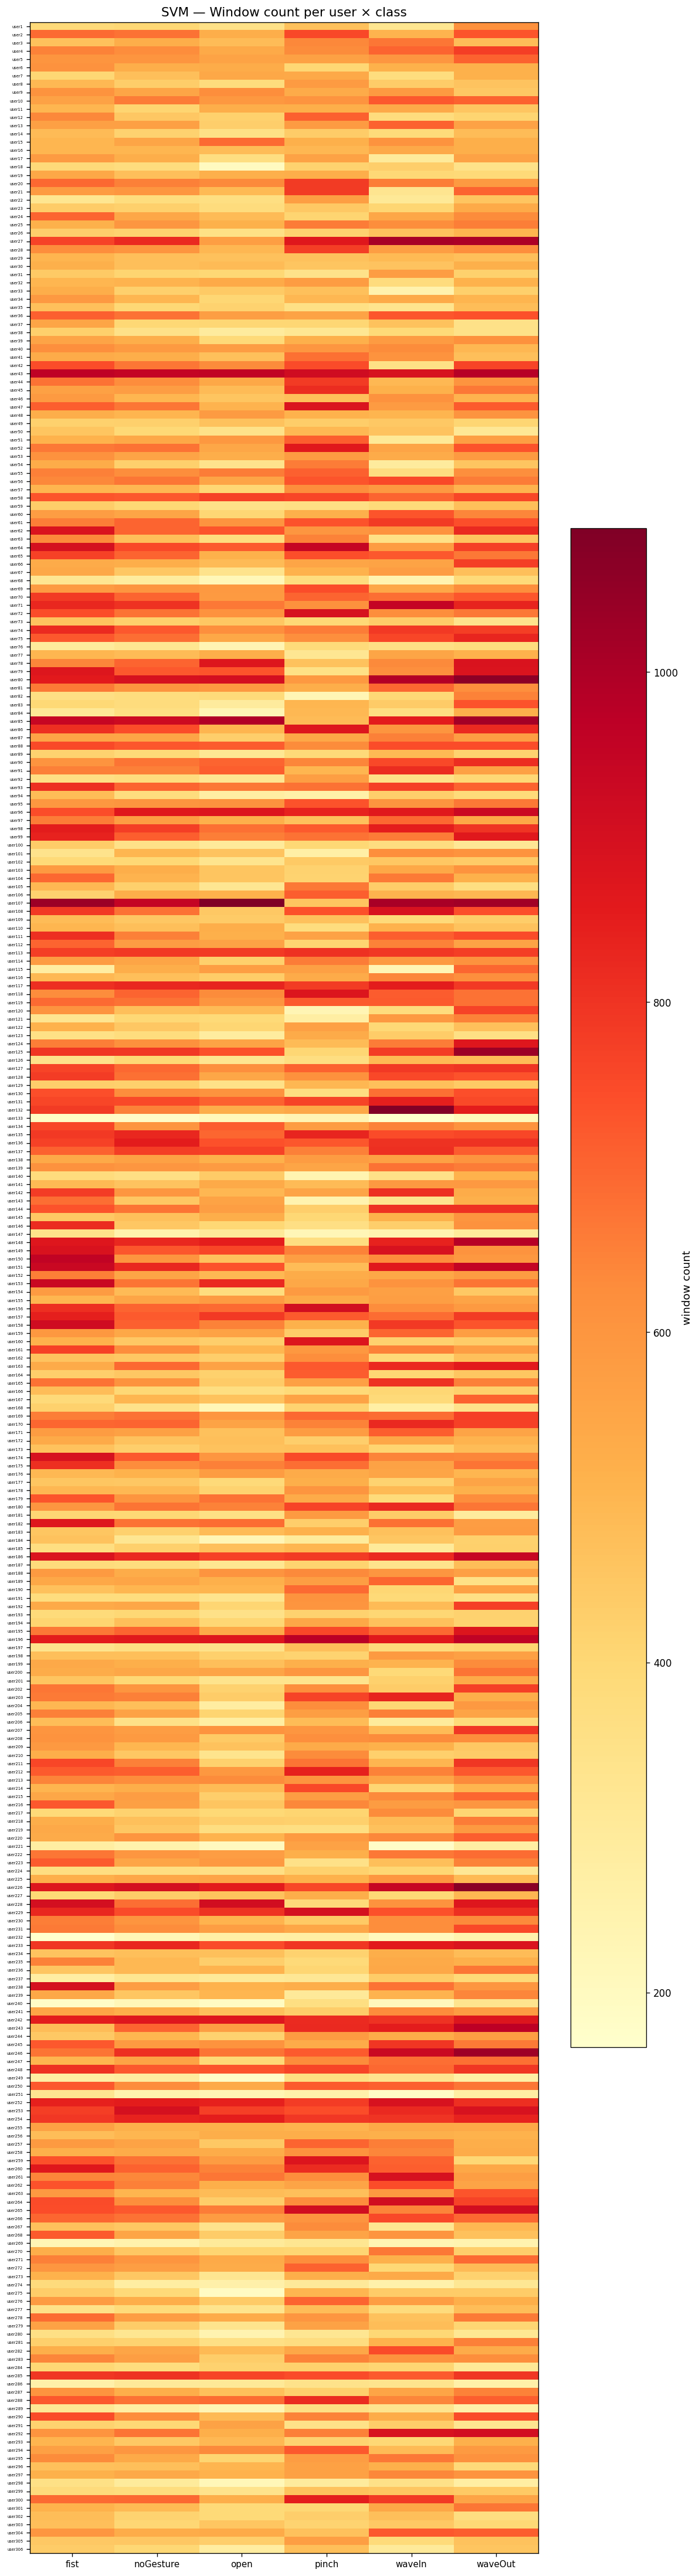

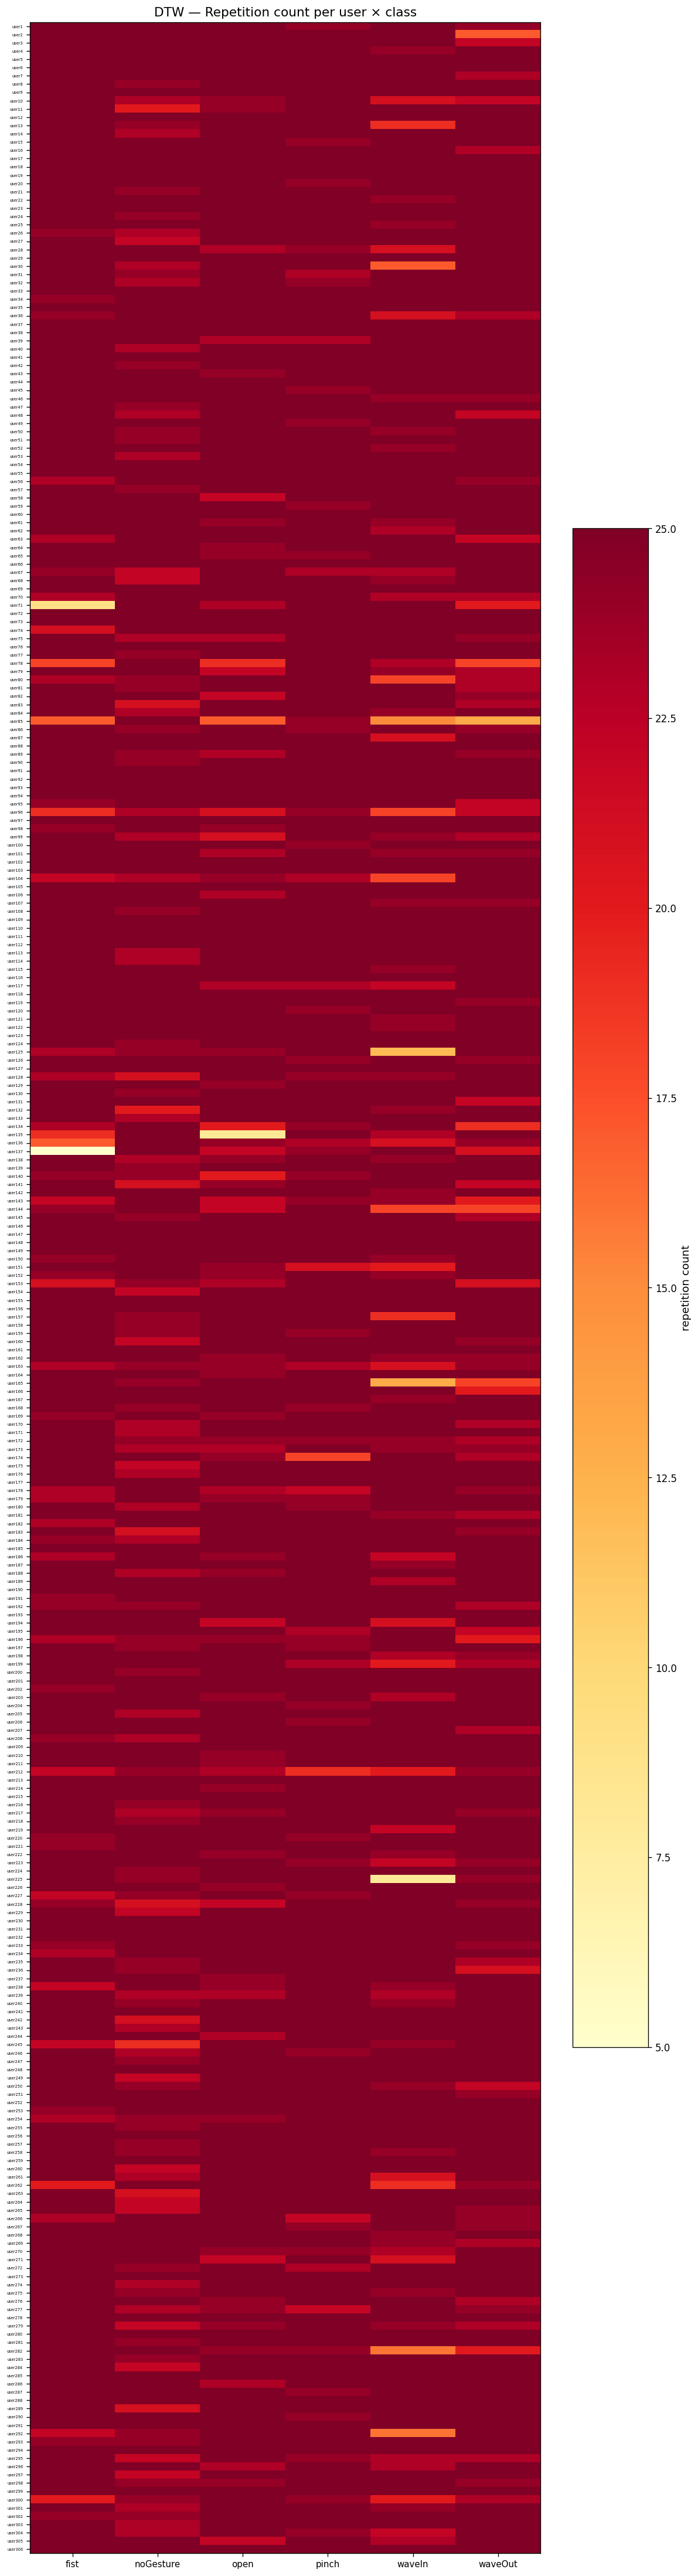

In [ ]:
pivot = df.groupby(["user", "label"]).size().unstack(fill_value=0)
pivot = pivot.reindex(columns=labels_order)
# sort users numerically
pivot = pivot.loc[sorted(pivot.index, key=lambda u: int(u.replace("user", "")))]

fig, ax = plt.subplots(figsize=(10, max(6, len(pivot) * 0.12)))
im = ax.imshow(pivot.values, aspect="auto", cmap="YlOrRd")
ax.set_yticks(range(0, len(pivot), max(1, len(pivot)//20)))
ax.set_yticklabels(pivot.index[::max(1, len(pivot)//20)], fontsize=5)
ax.set_xticks(range(len(labels_order)))
ax.set_xticklabels(labels_order, fontsize=9)
ax.set_title("TRAINING — Window count per user × class")
plt.colorbar(im, ax=ax, label="window count", shrink=0.6)
plt.tight_layout()
plt.show()

## 7 — Outlier Report: By Gesture

Analyse how many windows and registrations were flagged per gesture class. This reveals whether certain gestures are disproportionately affected by outlier removal.

,SVM (windows),DTW (repetitions)
label,,
fist,179631,7485
noGesture,168678,7426
open,154780,7498
pinch,171806,7563
waveIn,174138,7389
waveOut,182569,7458


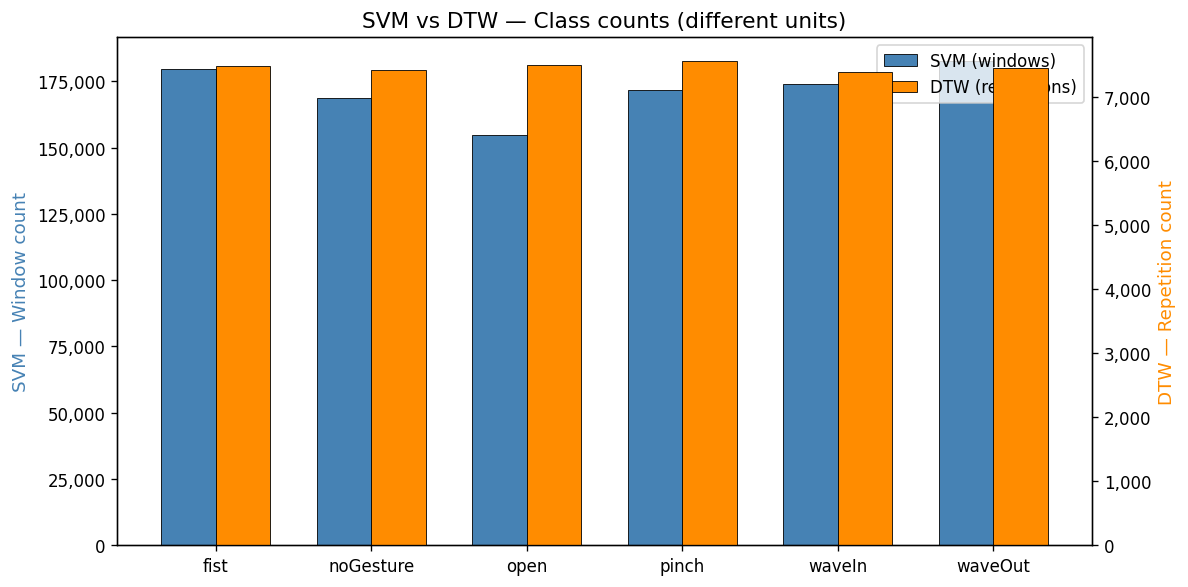

In [ ]:
display(rpt_gesture)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
gestures = rpt_gesture["gesture"].values
colours = plt.cm.Set2(np.linspace(0, 1, len(gestures)))

# ── 7a: % bad windows per gesture ───────────────────────────────────────
ax = axes[0]
bars = ax.bar(gestures, rpt_gesture["pct_bad_windows"], color=colours, edgecolor="black", linewidth=0.5)
for b, v in zip(bars, rpt_gesture["pct_bad_windows"]):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{v:.2f}%",
            ha="center", va="bottom", fontsize=8)
ax.set_title("Bad Windows per Gesture (%)")
ax.set_ylabel("% flagged as bad")
ax.set_xlabel("Gesture")

# ── 7b: % registrations affected per gesture ────────────────────────────
ax = axes[1]
bars = ax.bar(gestures, rpt_gesture["pct_reps_affected"], color=colours, edgecolor="black", linewidth=0.5)
for b, v in zip(bars, rpt_gesture["pct_reps_affected"]):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{v:.2f}%",
            ha="center", va="bottom", fontsize=8)
ax.set_title("Registrations with Outliers per Gesture (%)")
ax.set_ylabel("% registrations affected")
ax.set_xlabel("Gesture")

plt.tight_layout()
plt.show()

## 8 — Outlier Report: By User

Distribution of outlier intensity across users. Highlights which users have the most aggressive data removal.

,gesture,total_windows,bad_windows,pct_bad_windows,total_reps,clean_reps,interpolated_reps,dropped_reps,pct_dropped
0,fist,180610,979,0.54,7650,7321,164,165,2.16
1,noGesture,171325,2647,1.55,7650,7337,89,224,2.93
2,open,155749,969,0.62,7650,7299,199,152,1.99
3,pinch,172392,586,0.34,7650,7415,148,87,1.14
4,waveIn,175638,1500,0.85,7650,7122,267,261,3.41
5,waveOut,183718,1149,0.63,7650,7245,213,192,2.51


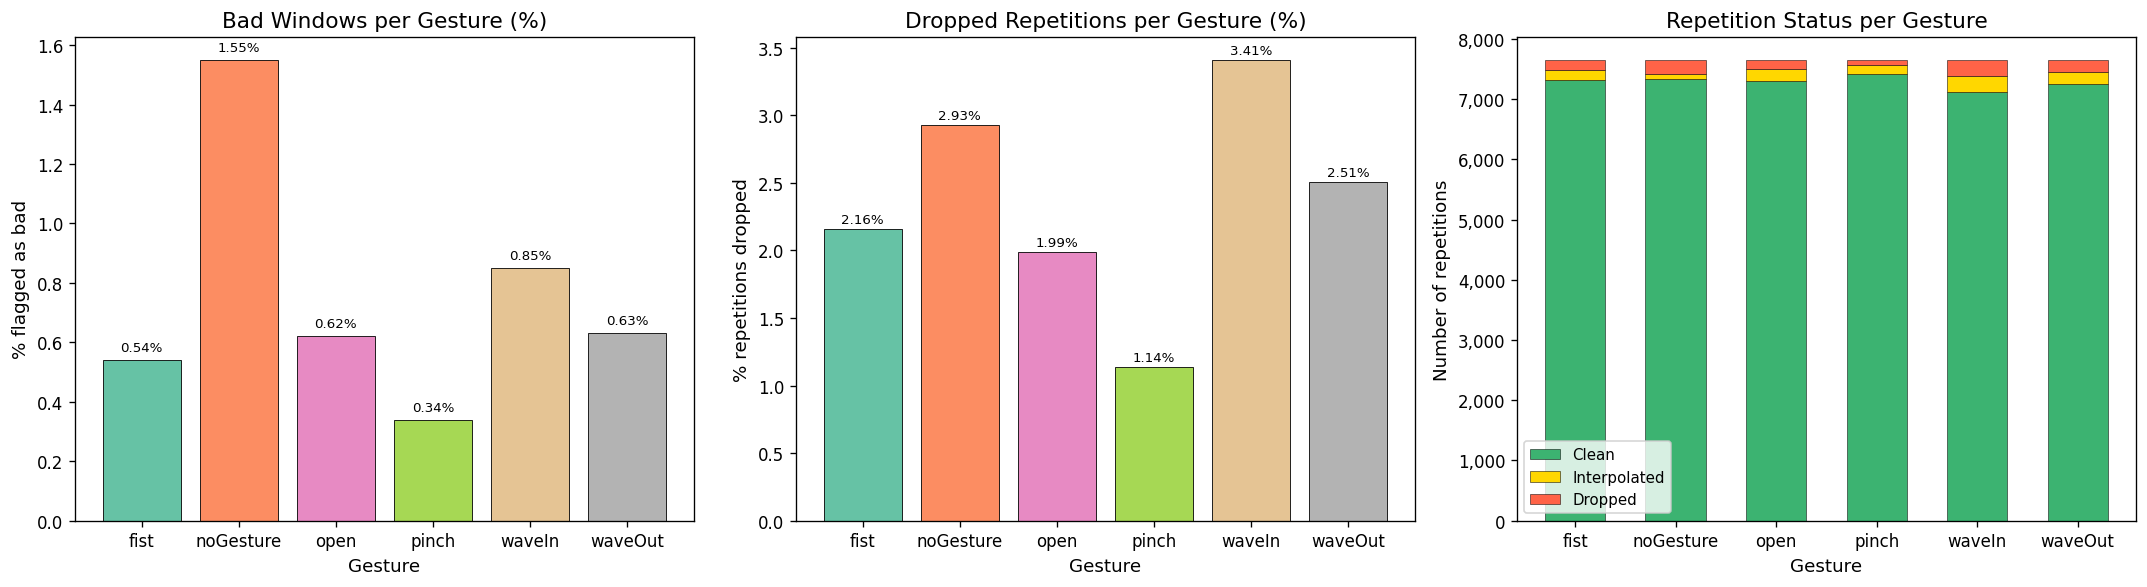

In [ ]:
# Sort users numerically
rpt_user_sorted = rpt_user.copy()
rpt_user_sorted["user_num"] = rpt_user_sorted["user"].str.replace("user", "").astype(int)
rpt_user_sorted = rpt_user_sorted.sort_values("user_num")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ── 8a: % bad windows per user (histogram) ─────────────────────────────
ax = axes[0, 0]
ax.hist(rpt_user_sorted["pct_bad_windows"], bins=30, color="steelblue", edgecolor="black", linewidth=0.5)
ax.axvline(rpt_user_sorted["pct_bad_windows"].median(), color="orange", ls="--",
           label=f"Median = {rpt_user_sorted['pct_bad_windows'].median():.2f}%")
ax.set_title("Distribution of % Bad Windows per User")
ax.set_xlabel("% bad windows")
ax.set_ylabel("Number of users")
ax.legend(fontsize=9)

# ── 8b: % affected registrations per user (histogram) ──────────────────
ax = axes[0, 1]
ax.hist(rpt_user_sorted["pct_reps_affected"], bins=30, color="tomato", edgecolor="black", linewidth=0.5)
ax.axvline(rpt_user_sorted["pct_reps_affected"].median(), color="orange", ls="--",
           label=f"Median = {rpt_user_sorted['pct_reps_affected'].median():.2f}%")
ax.set_title("Distribution of % Affected Registrations per User")
ax.set_xlabel("% registrations with outliers")
ax.set_ylabel("Number of users")
ax.legend(fontsize=9)

# ── 8c: % bad windows per user (sorted bar) ────────────────────────────
ax = axes[1, 0]
sorted_bad = rpt_user_sorted.sort_values("pct_bad_windows", ascending=False)
ax.bar(range(len(sorted_bad)), sorted_bad["pct_bad_windows"].values,
       width=1.0, color="steelblue", edgecolor="none")
ax.set_title("% Bad Windows per User (sorted, descending)")
ax.set_xlabel("Users (sorted)")
ax.set_ylabel("% bad windows")

# ── 8d: % affected registrations per user (sorted bar) ─────────────────
ax = axes[1, 1]
sorted_aff = rpt_user_sorted.sort_values("pct_reps_affected", ascending=False)
ax.bar(range(len(sorted_aff)), sorted_aff["pct_reps_affected"].values,
       width=1.0, color="tomato", edgecolor="none")
ax.set_title("% Affected Registrations per User (sorted, descending)")
ax.set_xlabel("Users (sorted)")
ax.set_ylabel("% registrations affected")

plt.tight_layout()
plt.show()

# ── Top-10 most affected users ──────────────────────────────────────────
print("\nTop 10 users by % bad windows:")
display(rpt_user_sorted.nlargest(10, "pct_bad_windows")[
    ["user", "total_windows", "bad_windows", "pct_bad_windows",
     "total_registrations", "reps_with_outliers", "pct_reps_affected"]
].reset_index(drop=True))

print("\nTop 10 users by % affected registrations:")
display(rpt_user_sorted.nlargest(10, "pct_reps_affected")[
    ["user", "total_windows", "bad_windows", "pct_bad_windows",
     "total_registrations", "reps_with_outliers", "pct_reps_affected"]
].reset_index(drop=True))

# ── Summary stats ───────────────────────────────────────────────────────
print("\nPer-user outlier statistics:")
display(rpt_user_sorted[["pct_bad_windows", "pct_reps_affected"]].describe().round(4))

## 9 — Outlier Report: User × Gesture Cross-Tab

Heatmap showing which (user, gesture) combinations suffer the most outlier removal. This can reveal if specific gestures are problematic only for certain users.

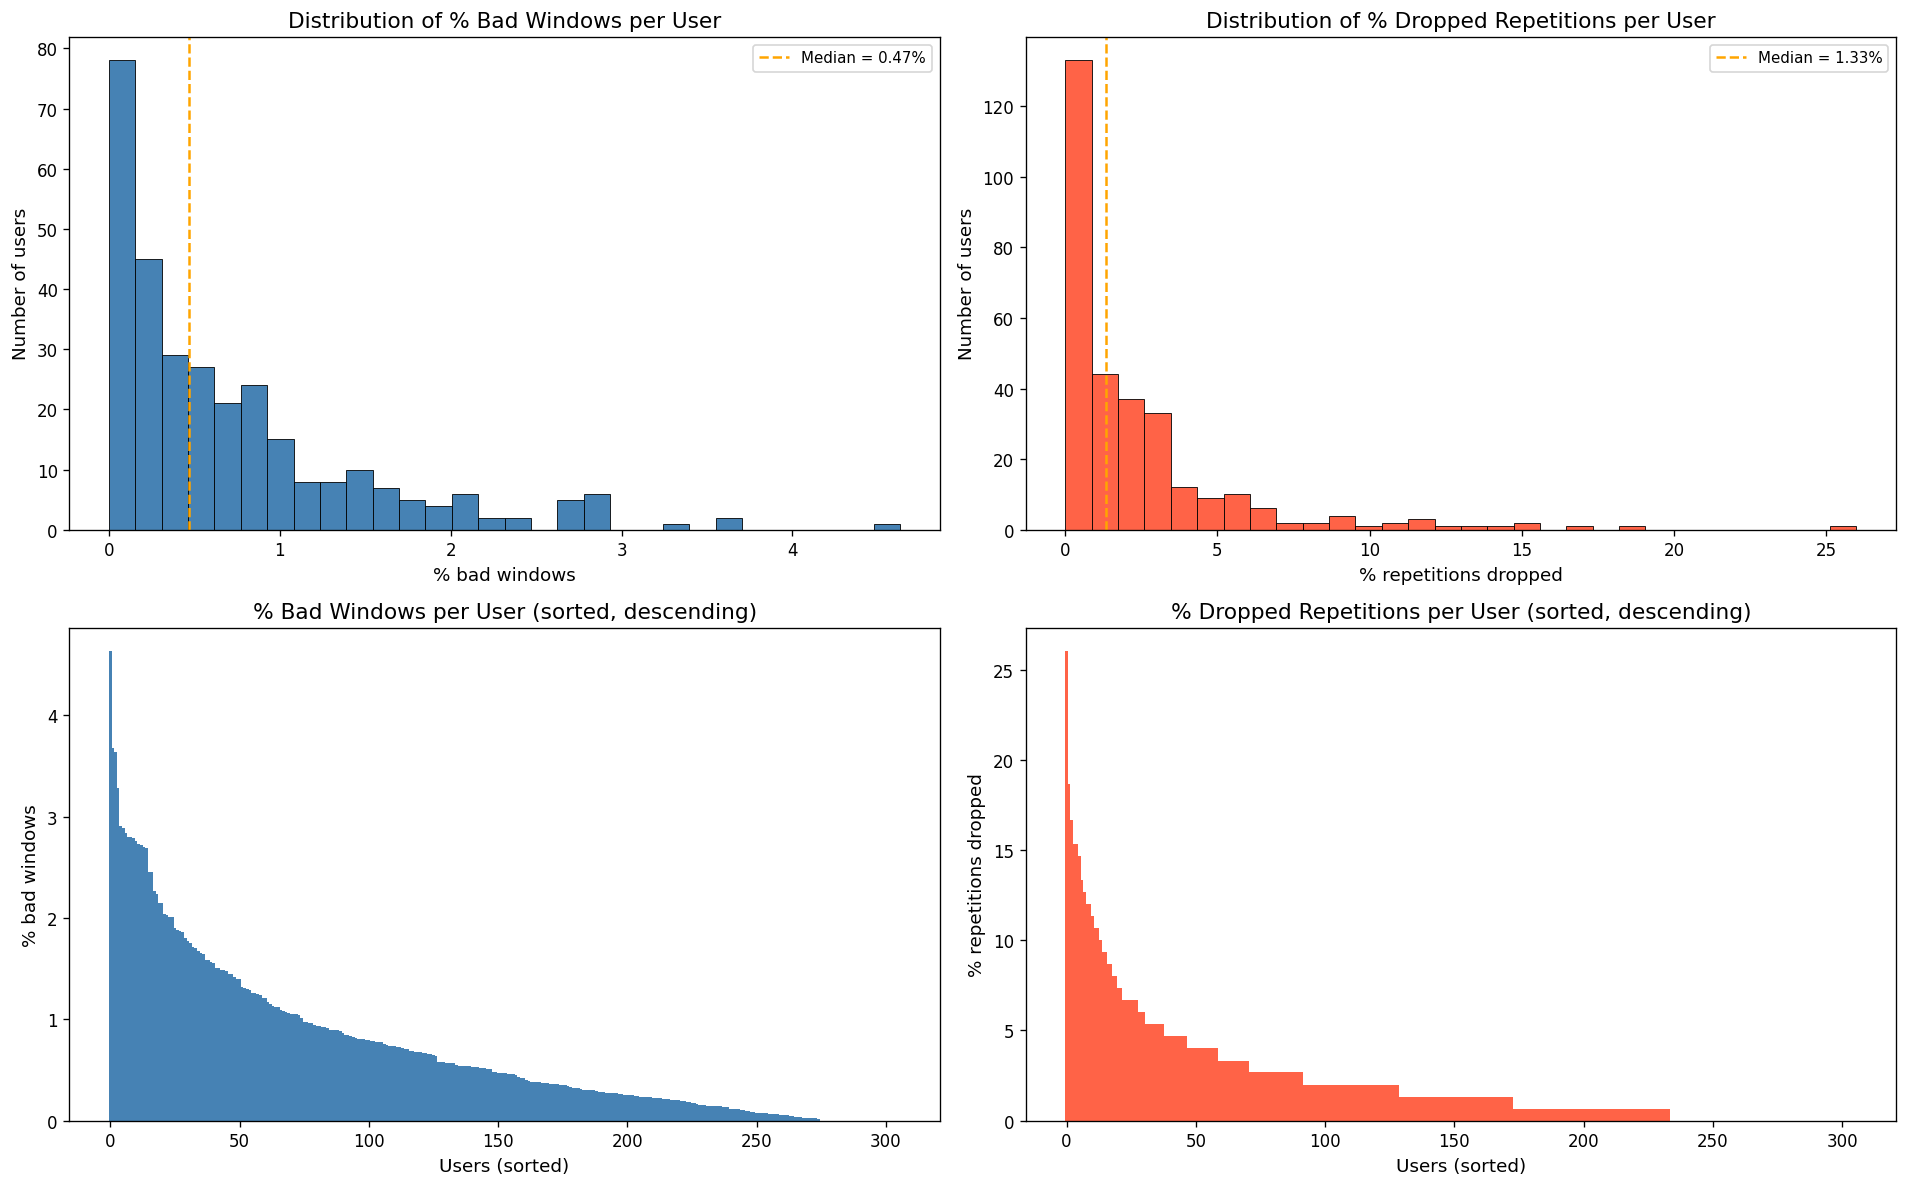


Top 10 users by % bad windows:


,user,total_windows,bad_windows,pct_bad_windows,dropped_reps,interpolated_reps,pct_dropped
0,user85,5467,253,4.63,39,13,26.00
1,user104,3366,124,3.68,15,26,10.00
2,user137,4587,167,3.64,28,12,18.67
3,user11,3049,100,3.28,6,3,4.00
4,user135,4782,139,2.91,25,30,16.67
5,user245,4014,116,2.89,10,6,6.67
6,user212,4359,124,2.84,18,6,12.00
7,user78,4318,121,2.80,22,17,14.67
8,user83,2817,79,2.80,6,1,4.00
9,user143,2863,80,2.79,13,8,8.67



Top 10 users by % dropped repetitions:


,user,total_windows,bad_windows,pct_bad_windows,dropped_reps,interpolated_reps,pct_dropped
0,user85,5467,253,4.63,39,13,26.00
1,user137,4587,167,3.64,28,12,18.67
2,user135,4782,139,2.91,25,30,16.67
3,user71,4818,130,2.70,23,9,15.33
4,user96,5238,119,2.27,23,12,15.33
5,user78,4318,121,2.80,22,17,14.67
6,user165,3844,105,2.73,20,8,13.33
7,user225,3309,90,2.72,19,13,12.67
8,user144,4128,114,2.76,18,24,12.00
9,user212,4359,124,2.84,18,6,12.00



Per-user outlier statistics:


,pct_bad_windows,pct_dropped
count,306.0000,306.0000
mean,0.7163,2.3555
std,0.7788,3.3536
min,0.0000,0.0000
25%,0.1500,0.6700
50%,0.4700,1.3300
75%,0.9675,2.6700
max,4.6300,26.0000


In [ ]:
# ── Pivot: % bad windows per (user, gesture) ────────────────────────────
pivot_bad = rpt_ug.pivot_table(
    index="user", columns="gesture", values="pct_bad_windows", fill_value=0
)
# Sort users numerically
pivot_bad = pivot_bad.loc[
    sorted(pivot_bad.index, key=lambda u: int(u.replace("user", "")))
]

fig, axes = plt.subplots(1, 2, figsize=(16, max(6, len(pivot_bad) * 0.08)))

# ── 9a: Heatmap of % bad windows ──────────────────────────────────────
ax = axes[0]
im = ax.imshow(pivot_bad.values, aspect="auto", cmap="YlOrRd", interpolation="nearest")
ax.set_yticks(range(0, len(pivot_bad), max(1, len(pivot_bad)//20)))
ax.set_yticklabels(pivot_bad.index[::max(1, len(pivot_bad)//20)], fontsize=5)
ax.set_xticks(range(len(pivot_bad.columns)))
ax.set_xticklabels(pivot_bad.columns, fontsize=9, rotation=45, ha="right")
ax.set_title("% Bad Windows per User × Gesture")
plt.colorbar(im, ax=ax, label="% bad windows", shrink=0.5)

# ── Pivot: reps_with_outliers per (user, gesture) ───────────────────────
pivot_affected = rpt_ug.pivot_table(
    index="user", columns="gesture", values="reps_with_outliers", fill_value=0
)
pivot_affected = pivot_affected.loc[
    sorted(pivot_affected.index, key=lambda u: int(u.replace("user", "")))
]

ax = axes[1]
im2 = ax.imshow(pivot_affected.values, aspect="auto", cmap="YlOrRd", interpolation="nearest")
ax.set_yticks(range(0, len(pivot_affected), max(1, len(pivot_affected)//20)))
ax.set_yticklabels(pivot_affected.index[::max(1, len(pivot_affected)//20)], fontsize=5)
ax.set_xticks(range(len(pivot_affected.columns)))
ax.set_xticklabels(pivot_affected.columns, fontsize=9, rotation=45, ha="right")
ax.set_title("Registrations with Outliers per User × Gesture")
plt.colorbar(im2, ax=ax, label="# affected regs", shrink=0.5)

plt.tight_layout()
plt.show()

# ── Mean % bad windows per gesture (aggregated from cross-tab) ──────────
print("Mean % bad windows per gesture (across all users):")
display(pivot_bad.mean().round(4).to_frame("mean_pct_bad").T)

# ── Which (user, gesture) combos have the most outliers? ────────────────
print("\nTop 15 user×gesture combos by bad windows:")
top_ug = rpt_ug.nlargest(15, "bad_windows")[
    ["user", "gesture", "total_registrations", "reps_with_outliers",
     "total_windows", "bad_windows", "pct_bad_windows"]
].reset_index(drop=True)
display(top_ug)

## 10 — Summary & Verdict

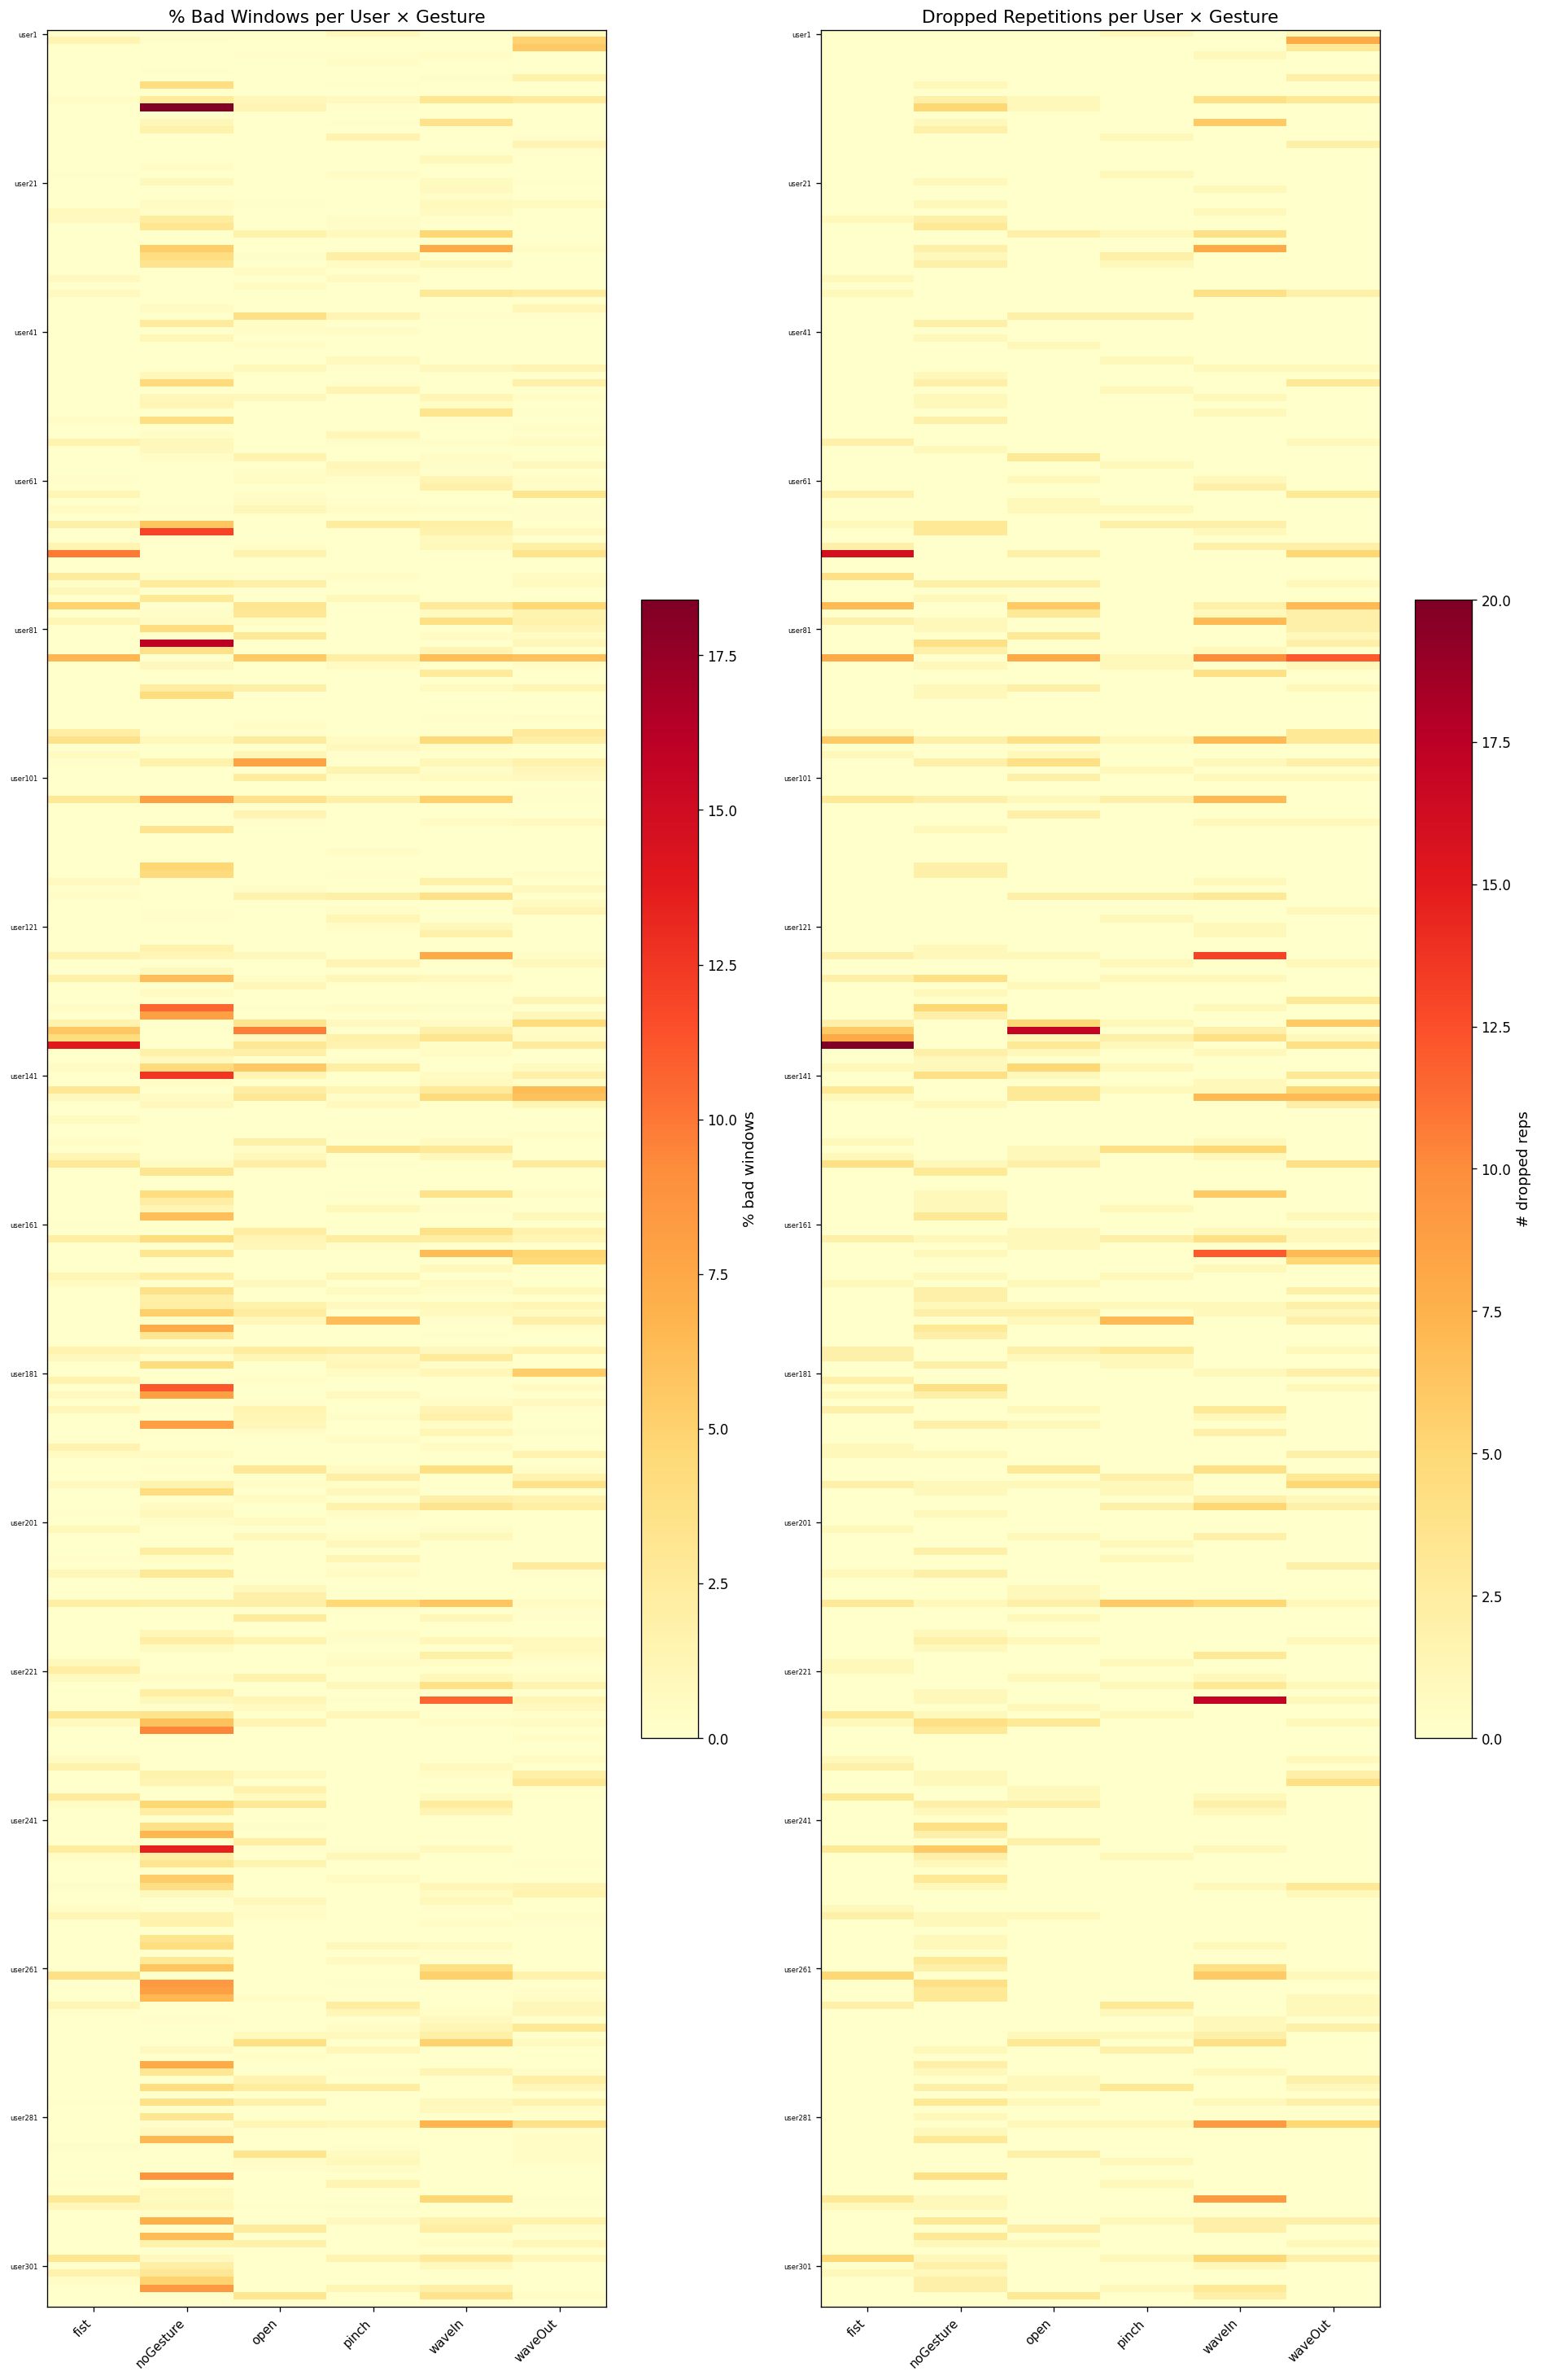

Mean % bad windows per gesture (across all users):


gesture,fist,noGesture,open,pinch,waveIn,waveOut
mean_pct_bad,0.4393,1.5769,0.5475,0.3306,0.7458,0.5765



Top 15 user×gesture combos by dropped repetitions:


,user,gesture,total_reps,dropped_reps,interpolated_reps,total_windows,bad_windows,pct_bad_windows
0,user137,fist,25,20,2,818,114,13.94
1,user135,open,25,17,6,771,75,9.73
2,user225,waveIn,25,17,6,666,71,10.66
3,user71,fist,25,16,6,918,91,9.91
4,user125,waveIn,25,13,3,842,62,7.36
5,user165,waveIn,25,12,5,855,54,6.32
6,user85,waveOut,25,12,3,1081,63,5.83
7,user85,waveIn,25,10,4,910,56,6.15
8,user282,waveIn,25,9,2,800,54,6.75
9,user292,waveIn,25,9,3,933,43,4.61


In [ ]:
labels_order = sorted(df["label"].unique())

# Recompute IR for summary
counts = df["label"].value_counts()
ir_val = counts.max() / counts.min()

def balance_verdict(ir):
    if ir < 1.1:   return "BALANCED"
    elif ir < 1.5: return "MILDLY IMBALANCED"
    elif ir < 3.0: return "MODERATELY IMBALANCED"
    else:          return "HIGHLY IMBALANCED"

# Outlier summary
total_win_before = rpt_gesture["total_windows"].sum()
total_bad_win    = rpt_gesture["bad_windows"].sum()
total_regs       = rpt_gesture["total_registrations"].sum()
total_affected   = rpt_gesture["reps_with_outliers"].sum()

print("=" * 64)
print("            DATASET BALANCE & OUTLIER SUMMARY")
print("=" * 64)
print()
print("  CLASS BALANCE")
print(f"  IR = {ir_val:.4f}  ->  {balance_verdict(ir_val)}")
print(f"  Classes: {len(labels_order)}  |  Total windows: {len(df):,}")
print()
print("  OUTLIER REMOVAL (before -> after)")
print(f"  Total windows before outlier removal : {total_win_before:>10,}")
print(f"  Bad windows flagged (removed)        : {total_bad_win:>10,}  "
      f"({total_bad_win/total_win_before*100:.2f}%)")
print(f"  Windows retained (dataset_TRAINING)  : {len(df):>10,}")
print()
print(f"  Total registrations                  : {total_regs:>10,}")
print(f"  Registrations with >= 1 bad window   : {total_affected:>10,}  "
      f"({total_affected/total_regs*100:.2f}%)")
print()
print("  MOST AFFECTED GESTURE (by % bad windows):")
worst = rpt_gesture.loc[rpt_gesture["pct_bad_windows"].idxmax()]
best  = rpt_gesture.loc[rpt_gesture["pct_bad_windows"].idxmin()]
print(f"    Worst: {worst['gesture']:<12s} -- {worst['pct_bad_windows']:.2f}% bad windows")
print(f"    Best : {best['gesture']:<12s} -- {best['pct_bad_windows']:.2f}% bad windows")
print()
print("  IR thresholds:")
print("    < 1.10  ->  Balanced")
print("    < 1.50  ->  Mildly imbalanced")
print("    < 3.00  ->  Moderately imbalanced")
print("    >= 3.00 ->  Highly imbalanced")
print("=" * 64)